# Using bodo to read and analyse NYC taxi data from 2015

This notebook aims to guide you throught the first steps using **bodo**. Also, it has some comparison an notes about the using **bodo** and pure python (+ numpy + pandas).

This example is based on [Matthew Rocklin blog post about dask]( https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes), so we highly recommend first you take a time to read that blog post. Here, we will focus on showing how to do the cited blog post code using **bodo** and show some information about the spent time for a pure pandas code and **bodo** code. We will add some comments about the changes we needed to do to have the code running using **bodo**.

## Setup

First, you probably will need to download the NYC Yellow taxi data from 2015.
Uncomment the following code and change the **DATA_DIR** to your local directory, so you can run the cell.

In [1]:
"""
%%bash

URL_ROOT=https://s3.amazonaws.com/nyc-tlc/trip+data
DATA_DIR=/work/bodoai/dataset/nyc-trip-2015

for i in {1..12}; do
    month=`printf "%2.0d\n" $i |sed "s/ /0/"`;
    FILENAME=yellow_tripdata_2015-${month}.csv;
    # wget -c ${URL_ROOT}/${FILENAME} -O ${DATA_DIR}/${FILENAME};
done
""";

As **bodo** **read_csv** works easily with constant paths than variable paths, you can link this folder inside our current path (optional, uncomment the code below if you want to run it).

In [2]:
"""
%%bash

mkdir -p ./data
ln -s /work/bodoai/dataset/nyc-trip-2015 ./data
""";

In [3]:
!ls ./data/nyc-trip-2015

q1.pq			     yellow_tripdata_2015-02.csv
yellow_tripdata_2015-01.csv  yellow_tripdata_2015-03.csv


As it is easier to work with `parquet` file than `csv` files, we will convert the `csv` files to a single `parquet` file (for now lets just use the first 3 files).

In [4]:
import pandas as pd

In [5]:
dfs = []
data_dir = './data/nyc-trip-2015'

for i in range(1, 4):
    df = pd.read_csv(
        f'{data_dir}/yellow_tripdata_2015-{str(i).rjust(2, "0")}.csv',
        parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
    )
    dfs.append(df)
    del df

df = pd.concat(dfs)
df.to_parquet('./data/nyc-trip-2015/q1.pq')
del df

In [6]:
!ls ./data/nyc-trip-2015

q1.pq			     yellow_tripdata_2015-02.csv
yellow_tripdata_2015-01.csv  yellow_tripdata_2015-03.csv


Now it is almost ready to start, lets just import `bodo` (and `time` for profiling). Also, import matplotlib for plotting charts!

In [7]:
import time
import bodo
import matplotlib.pyplot as plt

### Bodo px magic command

You can also use `%px` magic command to run your cell using 
[MPI](https://ipyparallel.readthedocs.io/en/latest/magics.html).

**NOTE:** check [bodo documentation](https://docs.bodo.ai/latest/source/user_guide.html)
for more information.

In [8]:
import ipyparallel as ipp
c = ipp.Client(profile="mpi")
view = c[:]
view.activate()
view.block = True
import os
view["cwd"] = os.getcwd()
%px cd $cwd

[stdout:0] /home/xmn/dev/bodoai/bodo-benchmarks/notebooks
[stdout:1] /home/xmn/dev/bodoai/bodo-benchmarks/notebooks
[stdout:2] /home/xmn/dev/bodoai/bodo-benchmarks/notebooks
[stdout:3] /home/xmn/dev/bodoai/bodo-benchmarks/notebooks


# Load data from CSV files

For an experimental purpose, it is using just the first 3 months of 2015, 
it is about 6GB in disk and 30 GB in RAM (for loading the data, not the dataframe in memory).

In [9]:
def read_data():
    t0 = time.time()
    df = pd.read_parquet('./data/nyc-trip-2015/q1.pq')
    t1 = time.time()
    print('read_data execution time:', t1 - t0, 's')
    return df

df = read_data()

read_data execution time: 3.507601499557495 s


Lets check some information about the dataframe:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38551116 entries, 0 to 13351608
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RateCodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

Now, using bodo:

In [11]:
read_data = bodo.jit(read_data)

df = read_data()

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'read_data'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


read_data execution time: 9.118767976760864 s


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38551116 entries, 0 to 13351608
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RateCodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

**NOTE:** As you can see the consumed time was more than the python pure version. Probably it can have more benefits when using more data.

## Basic Aggregations and Groupbys

Let's try some basic aggregation on our dataframe:

In [13]:
def mean_by_each_passanger_count(df):
    t0 = time.time()
    trip_distance_mean = df.groupby('passenger_count').trip_distance.mean()
    t1 = time.time()
    print('\nmean_by_each_passanger_count execution time:', t1 - t0, 's')
    return trip_distance_mean


trip_distance_mean = mean_by_each_passanger_count(df)
print(trip_distance_mean)


mean_by_each_passanger_count execution time: 0.5278885364532471 s
passenger_count
0     2.245734
1    16.757501
2    12.369026
3   -18.456581
4    14.271708
5     2.912368
6     2.838362
7     4.658491
8     2.426512
9     5.477000
Name: trip_distance, dtype: float64


**NOTE:** Originally, the `groupby` was applied using `df.groupby('passenger_count')`, but this structure is not supported by `bodo` yet.

In [14]:
mean_by_each_passanger_count = bodo.jit(mean_by_each_passanger_count)

trip_distance_mean = mean_by_each_passanger_count(df)

print(trip_distance_mean)

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'mean_by_each_passanger_count'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(



mean_by_each_passanger_count execution time: 1.1836318969726562 s
passenger_count
1    16.757501
3   -18.456581
2    12.369026
5     2.912368
6     2.838362
4    14.271708
0     2.245734
9     5.477000
7     4.658491
8     2.426512
Name: trip_distance, dtype: float64


<ipython-input-15-3fb56b97724f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tip_fraction'] = df2.tip_amount / df2.fare_amount
<ipython-input-15-3fb56b97724f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour'] = df2.tpep_pickup_datetime.dt.hour



calc_tip_by_hour execution time: 6.289813995361328 s


<AxesSubplot:xlabel='hour'>

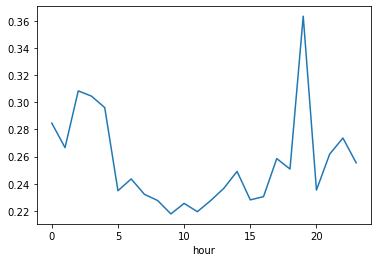

In [15]:
def calc_tip_by_hour(df):
    t0 = time.time()
    
    df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]
    df2['tip_fraction'] = df2.tip_amount / df2.fare_amount
    df2['hour'] = df2.tpep_pickup_datetime.dt.hour
    
    hour = df2.groupby('hour').tip_fraction.mean()
    
    t1 = time.time()
    print('\ncalc_tip_by_hour execution time:', t1 - t0, 's')
    
    return hour

tip_by_hour = calc_tip_by_hour(df)
tip_by_hour.plot()

**NOTE:** Originally, the `groupby` was applied directly using `df2.groupby(df2.tpep_pickup_datetime.dt.hour)`
but this structure is not supported by `bodo` yet.

And, using **bodo**:

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_tip_by_hour'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(



calc_tip_by_hour execution time: 2.666127920150757 s


<AxesSubplot:xlabel='hour'>

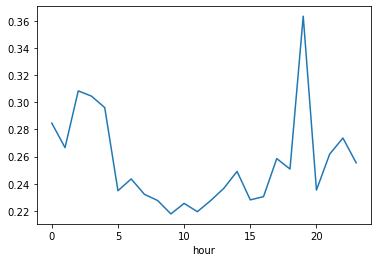

In [16]:
calc_tip_by_hour = bodo.jit(calc_tip_by_hour)

tip_by_hour = calc_tip_by_hour(df).sort_index()
tip_by_hour.plot()

**NOTE**: The result needed to be ordered manually by index.

If we plot our data and add a line with the average of the tips, we can see that 
the tips are better in the first hours and last hours of the day.

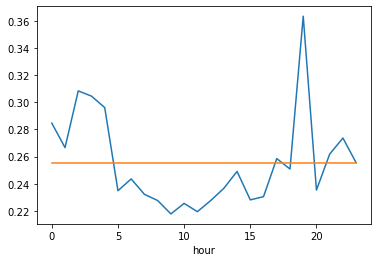

In [17]:
tip_by_hour.plot()
plt.plot(tip_by_hour.index, [tip_by_hour.mean()] * tip_by_hour.index.size)

## Joins and Correlation

[**Data Frame Joins**](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) are very similar to databases [**SQL joins**](https://en.wikipedia.org/wiki/Join_(SQL)). So, basically they are different ways to combine to resource data.

So, lets play with our data:

- create a `series` that will map the `payment_type ID` to the payment name;
- join this series with the original data;
- show the average tip for each type of payment;

To get it working with **bodo**, we need to check some recommendations from the [documentation page](https://docs.bodo.ai/latest/source/pandas.html#general-functions) method:

- Arguments `left`, `right` should be dataframes.
- `how`, `on`, `left_on`, `right_on`, `left_index`, and `right_index` are supported but should be constant values.
- The output dataframe is not sorted by default for better parallel performance (Pandas may preserve key order depending on how). One can use explicit sort if needed.

**NOTE:** the parameters for columns should be constant string instead of the data frame column object, for example, instead of `df.payment_type` use just `'payment_type'`.

**NOTE:** at this moment there is a bug related to join with index with **bodo**. the problem was already fixed and the solution will be available soon.

In [18]:
def calc_average_by_payment_type(df):
    t0 = time.time()
    payments = pd.DataFrame({
        'payment_name': [
            'Credit Card',
            'Cash',
            'No Charge',
            'Dispute',
            'Unknown',
            'Voided trip'
        ], "IDX": [1, 2, 3, 4, 5, 6]
    },)
    df2 = df.merge(payments, left_on='payment_type', right_on="IDX")
    result = df2.groupby('payment_name').tip_amount.mean()
    t1 = time.time()
    print('calc_average_by_payment_type execution time:', t1 - t0, 's')
    return result


result = calc_average_by_payment_type(df)
print(result.shape)
result

calc_average_by_payment_type execution time: 14.066501140594482 s
(5,)


payment_name
Cash           0.000232
Credit Card    2.758297
Dispute       -0.012648
No Charge      0.005050
Unknown        0.000000
Name: tip_amount, dtype: float64

In [19]:
calc_average_by_payment_type = bodo.jit(calc_average_by_payment_type)

result = calc_average_by_payment_type(df)
result.sort_index()

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_average_by_payment_type'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


calc_average_by_payment_type execution time: 4.786678075790405 s


payment_name
Cash           0.000232
Credit Card    2.758297
Dispute       -0.012648
No Charge      0.005050
Unknown        0.000000
Name: tip_amount, dtype: float64

As we can see the average tip for *Cash* is very close to zero. Lets take a look with there is any correlation between cash payment and no tips (using Pearson correlation).

In [20]:
def calc_corr_cash_tip(df):
    t0 = time.time()
    payments = pd.DataFrame({
        'payment_name': [
            'Credit Card',
            'Cash',
            'No Charge',
            'Dispute',
            'Unknown',
            'Voided trip'
        ], "IDX": [1, 2, 3, 4, 5, 6]
    },)
    df2 = df.merge(payments, left_on='payment_type', right_on="IDX")
    
    zero_tip = df2.tip_amount == 0
    cash = df2.payment_name == 'Cash'

    result = pd.concat([zero_tip, cash], axis=1).corr()
    
    t1 = time.time()
    print('calc_corr_cash_tip execution time:', t1 - t0, 's')
    return result

calc_corr_cash_tip(df)

calc_corr_cash_tip execution time: 14.031903982162476 s


,tip_amount,payment_name
tip_amount,1.000000,0.944893
payment_name,0.944893,1.000000


And, using **bodo**:

In [21]:
calc_corr_cash_tip = bodo.jit(calc_corr_cash_tip)

result = calc_corr_cash_tip(df)
result.sort_index()

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_corr_cash_tip'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


calc_corr_cash_tip execution time: 3.9850640296936035 s


,0,1
0,1.000000,0.944893
1,0.944893,1.000000


And as we can see, there is a high correlation between paying in cash with no tip.

## Shuffles and Time Series

As mentioned by Matthew Rocklini in his [blog post](https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes), `suffle` is the base of computations like `groupby-apply`, distributed joins on columns that are not the index, etc.

Let's check how it performes with pure `pandas` and `bodo`.

In [22]:
def set_tpep_pickup_datetime_as_index(df):
    t0 = time.time()
    result = df.set_index('tpep_pickup_datetime')
    t1 = time.time()
    print('set_tpep_pickup_datetime_as_index execution time:', t1 - t0, 's')
    return result


result = set_tpep_pickup_datetime_as_index(df)
result.head()

set_tpep_pickup_datetime_as_index execution time: 1.3675172328948975 s


,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,
2015-01-15 19:05:39,2,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
2015-01-10 20:33:38,1,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2015-01-10 20:33:38,1,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
2015-01-10 20:33:39,1,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
2015-01-10 20:33:39,1,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


Now, that the dataframe has been indexed with date and time format, the time series functionallity is available:

calc_passenger_count_by_day execution time: 9.475220918655396 s


<AxesSubplot:xlabel='tpep_pickup_datetime'>

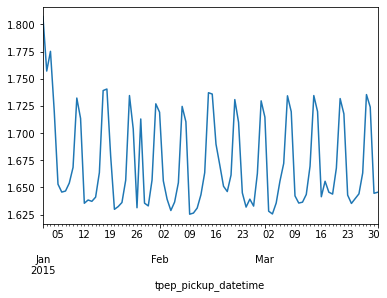

In [23]:
def calc_passenger_count_by_day(df):
    t0 = time.time()
    result = df.passenger_count.resample('1d').mean()
    t1 = time.time()
    print('calc_passenger_count_by_day execution time:', t1 - t0, 's')
    return result


calc_passenger_count_by_day(result).plot()

And, as always, using **bodo**:

In [24]:
set_tpep_pickup_datetime_as_index = bodo.jit(set_tpep_pickup_datetime_as_index)

result = set_tpep_pickup_datetime_as_index(df)
result.head()

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'set_tpep_pickup_datetime_as_index'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


set_tpep_pickup_datetime_as_index execution time: 0.9352290630340576 s


,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,
2015-01-15 19:05:39,2,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
2015-01-10 20:33:38,1,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2015-01-10 20:33:38,1,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
2015-01-10 20:33:39,1,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
2015-01-10 20:33:39,1,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


**NOTE:** at this moment, `calc_passenger_count_by_day` cannot be used with **bodo** because `Series.resample` is not supported yet.

## Parquet

According to the [Parquet web page](https://parquet.apache.org/):

> Apache Parquet is a columnar storage format available to any project in the Hadoop ecosystem, regardless of the choice of data processing framework, data model or programming language.

This blog post is already using `parquet` file for data storage.

## Final thoughts

Although the **bodo** functions have showed a better performance (~20x faster), we need to take in account that the measured was done inside the function and it didn't considered the time for the entire workflow. For example:

In [25]:
def calc_tip_average_by_payment(df):
    return df.groupby('payment_type').tip_amount.mean()


t0 = time.time()
result = calc_tip_average_by_payment(df)
t1 = time.time()

display(result)
print('calc_tip_average_by_payment execution time:', t1 - t0, 's')

payment_type
1    2.758297
2    0.000232
3    0.005050
4   -0.012648
5    0.000000
Name: tip_amount, dtype: float64

calc_tip_average_by_payment execution time: 0.4486424922943115 s


In [26]:
calc_tip_average_by_payment = bodo.jit(calc_tip_average_by_payment)

t0 = time.time()
result = calc_tip_average_by_payment(df)
t1 = time.time()

display(result)
print('calc_tip_average_by_payment execution time:', t1 - t0, 's')

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_tip_average_by_payment'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


payment_type
1    2.758297
2    0.000232
3    0.005050
4   -0.012648
5    0.000000
Name: tip_amount, dtype: float64

calc_tip_average_by_payment execution time: 1.6555366516113281 s


As you can see the bodo function is more than 3 times slower than the pure `pandas` version. Also, if we run it for once again, the diffence is very low.

In [27]:
t0 = time.time()
result = calc_tip_average_by_payment(df)
t1 = time.time()

display(result)
print('calc_tip_average_by_payment execution time:', t1 - t0, 's')

payment_type
1    2.758297
2    0.000232
3    0.005050
4   -0.012648
5    0.000000
Name: tip_amount, dtype: float64

calc_tip_average_by_payment execution time: 1.0147950649261475 s


If we measure the time inside the function, we can observe that the used time is very short.

In [28]:
@bodo.jit
def calc_tip_average_by_payment(df):
    t0 = time.time()
    result = df.groupby('payment_type').tip_amount.mean()
    t1 = time.time()
    print('calc_tip_average_by_payment execution time:', t1 - t0, 's')
    return result


calc_tip_average_by_payment(df)

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_tip_average_by_payment'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


calc_tip_average_by_payment execution time: 0.9820868968963623 s


payment_type
1    2.758297
2    0.000232
3    0.005050
4   -0.012648
5    0.000000
Name: tip_amount, dtype: float64

## References

The original blob post that was used as inspiration here can be accessed at:
- https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes

For more informations about `bodo, check out its documentation page:
- https://docs.bodo.ai/latest/source/user_guide.html

And maybe you will find useful some extra information about spme `pandas` commands used:

- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

Also, if you want to check out some extra comment about some SQL topics:

- https://en.wikipedia.org/wiki/Join_(SQL)

For more information about Pearson correlation:

- https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Parquet documentation page:

- https://parquet.apache.org/documentation/latest/